In [1]:
%matplotlib notebook

In [2]:
# Import python modules
import numpy as np
import pandas as pd
from shapely.geometry import Point, LineString, MultiPoint, Polygon
from sklearn.gaussian_process.kernels import Matern
from shapely.wkt import loads
from scipy.spatial.ckdtree import cKDTree
import matplotlib.pyplot as plt
#import rasterio
import netCDF4
import h5py
import gc, sys, os
sys.path.append("../scripts")
import spatial_functions
import aem_utils
import netcdf_utils
import modelling_utils
import plotting_functions as plots
import warnings
warnings.filterwarnings('ignore')

# 1. Load AEM inversions into notebook

Within this notebook environment, the inversions we will be using will be instances of the AEM_inversion class. A class is a feature of python programming that allows the bundling of data and methods. Here we use two inversions, the deterministic laterally constrained inversion and the stochastic GA reversible-jump Markov Chain Monte Carlo TDEM (GARJMCMCTDEM) inversion. We will demonstrate how to access these inversions by creating an instnace of the AEM class for each.

In [3]:
# The actual inversoin data are stored on disk as netcdf files. NetCDF is an efficient format for storing 
# self-describing containerised data. 
# The implementation of netcdf for AEM line data was done by Alex Ip using his geophys_utils package.
# https://github.com/GeoscienceAustralia/geophys_utils/tree/master/geophys_utils

# Define path to the netcdf file
infile = "../../workshop_data/lci/DalyR_WB_MGA52.nc"

# Create an instance
lci = aem_utils.AEM_inversion(name = 'Laterally Contrained Inversion (LCI)',
                              inversion_type = 'deterministic',
                              netcdf_dataset = netCDF4.Dataset(infile))

# As these inversions have already been gridded we will add these raster datasets to the instance using the
# load_lci_layer_grid() function. This function belongs to the AEM_inversion class.

# Directory in which the grids are located
inRaster = "../../workshop_data/lci/lci_grids"

# Run function
lci.load_lci_layer_grids(inRaster, conversion_to_SI = True, nlayers = 30)



Let examine the results of this process. The inversion data is stored as an attribute of the inversion
class lci. It can be accessed by running the 'lci.data' command.


In [4]:
print(lci.data)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    geospatial_east_min: 684789.625
    geospatial_east_max: 910249.5
    geospatial_east_units: m
    geospatial_north_min: 8309173.0
    geospatial_north_max: 8495335.0
    geospatial_north_units: m
    title: Dataset read from ASEG-GDF file DalyR_WB_MGA52_temp.dat
    Conventions: CF-1.6,ACDD-1.3
    featureType: trajectory
    geospatial_vertical_min: 
    geospatial_vertical_max: 302.2
    geospatial_vertical_units: m
    geospatial_vertical_resolution: point
    geospatial_vertical_positive: up
    history: Converted from ASEG-GDF file C:\Users\PCUser\Desktop\NSC_data\data\AEM\DR\2017_DalyRiver_SkyTEM\03_LCI\01_Data\DalyR_WB_MGA52_temp.dat using definitions file C:\Users\PCUser\Desktop\NSC_data\data\AEM\DR\2017_DalyRiver_SkyTEM\03_LCI\01_Data\DalyR_WB_MGA52.dfn
    date_created: 2019-10-07T16:54:15.324169
    geospatial_east_resolution: point
    geospatial_north_resolution: point
    geospatial

In [5]:
# The attributes and properties of the instance of the AEM inversion class can be viewed with the dir() command.

print(dir(lci))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'coords', 'data', 'grid_sections', 'grid_variables', 'inversion_type', 'layer_grids', 'load_gridded_sections', 'load_lci_layer_grids', 'load_sections_from_file', 'name', 'xmax', 'xmin', 'ymax', 'ymin']


Create an instance of the garjmcmctdem inversion and probe the results using the same syntax as above.

In [6]:
# Path to netcdf file
infile = r"../../workshop_data/rj/DR_rjmcmc_pmaps.nc"

# Create instance
rj = aem_utils.AEM_inversion(name = 'GARJMCMCTDEM',
                              inversion_type = 'stochastic',
                              netcdf_dataset = netCDF4.Dataset(infile))

Here we examine some of the attributes of the rj class

In [7]:
# here we print a few of the attributes
print(rj.data)
print("This inversions is named ", rj.name)
print("The most south-west point in the survey has coordinates of (" + str(rj.xmin) + ',' + str(rj.ymin) + ')')

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    nlayers_min: 1
    nlayers_max: 25
    nsamples: 500000
    nchains: 8
    nburnin: 50000
    thinrate: 10
    min_log10_conductivity: -3.0
    max_log10_conductivity: 0.0
    min_depth: 0.0
    max_depth: 400.0
    value_parameterization: LOG10
    position_parameterization: LINEAR
    keywords: geophysics, airborne, AEM, conductivity, garjmcmcmtdem
    date_created: 2020-07-15 00:12:57.153566
    crs: GDA94 / MGA zone 52
    crs_geographic: GDA2020
    geospatial_east_min: 736897.38
    geospatial_east_max: 838798.69
    geospatial_east_units: m
    geospatial_north_min: 8363871.0
    geospatial_north_max: 8469587.0
    geospatial_north_units: m
    geospatial_vertical_min: 36.81
    geospatial_vertical_max: 155.63
    geospatial_vertical_units: m
    geospatial_lon_min: 131.191645950018
    geospatial_lon_max: -13.833624150977913
    geospatial_lont_units: degrees North
    geospatial_lat_min: 

In [8]:
# Now we have the lines we can grid the lci conductivity data onto vertical grids (known as sections)
# this is the easiest way to visualise the AEM conuctivity in 2-dimensions

# Assign the lci variables to grid
grid_vars = ['conductivity', 'data_residual']

# Define the resolution of the sections
xres, yres = 20., 4.

# We will use the lines from the rj

lines = np.unique(rj.data['line'][:].astype('int'))

print(lines)

# Define the output directory if saving the grids as hdf plots

hdf5_dir = "../../workshop_data/lci/hdf5"

# if the directory doesn't exist, then create it
if not os.path.exists(hdf5_dir):
    os.mkdir(hdf5_dir)  

# Gridding takes a few minutes so I pre-gridded them for you. The lci.grid_sections()
# function below will do the gridding for you. Instead we will use the load_sectoin_from_file()
# function, which loads hdf5 files produced using the grid_sections() function


#lci.grid_sections(variables = grid_vars, lines = lines, xres = xres, yres = yres,
#                  return_interpolated = True, save_hdf5 = True, hdf5_dir = hdf5_dir)

lci.load_sections_from_file(hdf5_dir, grid_vars)

[102201 102301 102401 102501 102701 102801 102901 103001 103101 103201
 103301 103401 103501 103502 103601 103701 103801 103901 104001 104101
 104102 104201 104301 104401 104501 104601 104701 104801 104901 105001
 105101 105201 105301 105401 105501 105602 105701 105801 105901 105902
 106001 106101 106201 106301 106401 108001 108601 109203 109302 109401
 109502 109601 109701 110102 110103 110201 912005]


# 2. Visualise the data


Now let's quickly visualise the data. You can easily create your own plots if you are comfortable with the matplotlib python 
package. However, you may prefer to use some of the standard plots.

# 2.1 Interactive map plot

Our first standard plot is an intereactive plot of gridded conductivity with the points inverted with GARJMCMCTDEM
plotted as points. We have added an interactive component where by clicking on the plot, the point index of the
nearest GARJMCMC point gets added to a list of point (called points). This can be used at a later time for choosing points to interpret.

In [9]:
import importlib
importlib.reload(plots)

<module 'plotting_functions' from '../scripts/plotting_functions.py'>

<IPython.core.display.Javascript object>


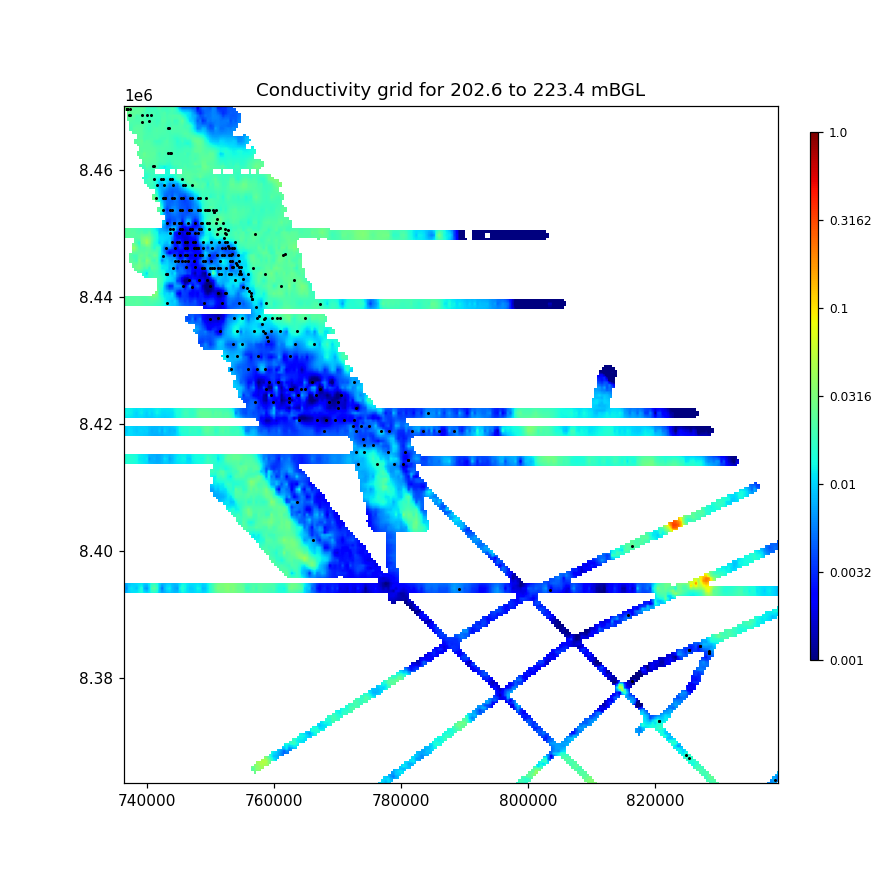

In [57]:
# We can add points that we wish to interpret to this list
points = []


# This is an interactive function that returns the index of a point if it is clicked on.
# if th point is within 5000. metres
def on_map_click(event):
    global point_index
    if event.xdata != None:
        x_, y_ = event.xdata, event.ydata
        distances, indices = spatial_functions.nearest_neighbours([x_,y_], rj.coords, max_distance = 5000.)
        point_index = indices[0]
        points.append(point_index)
        print('Point index is ', point_index)
        
# In this notebook, standard plot key word arguments are passed to the plotting function as a python dictionary

# Here we explain each variable. Feel free to change and regenerate the plot
plot_args = {'Layer_number': 20, # Which AEM layer grid to plot from layer 1 (shallowest) to 30 (deepest)
             "figsize": (8,8), # The figure size in inches
             "vmin": 0.001, "vmax": 1., # The maximum and minimum conductivities in (S/m) for the grid colourstretch
             "point_size": 1, "point_colour": 'black', # Size and colour of the scatter plot points
             'colour_stretch': 'jet', # See matplotlib colourstretches
             'buffer': 500.} # The plot boundary will be buffered around the outer most scatter points.

plt.close('all')
# Do some plotting

fig, ax, cax = plots.AEM_baseplot(rj, lci, plot_args = plot_args)

# You can edit the ax (grid panel) and cax (colourbar axis) using matplotlib axis function
# for example uncomment and run the follwoing line
#ax.set_xlim(740000, 760000)

cid =  fig.canvas.mpl_connect('button_press_event', on_map_click)

plt.show()

In [58]:
print(points)

[98, 28, 228, 169, 170, 242, 245, 257, 268, 281, 288, 287, 287, 296, 294, 294, 298, 308, 311, 311, 300, 291, 277, 277, 234]


# 2.2 Section plot

Our next standard plot is a vertical AEM section. The rather irregular length of sections means these are
commonly customised. As such we have left it to the user to define the size of the panels.

<IPython.core.display.Javascript object>


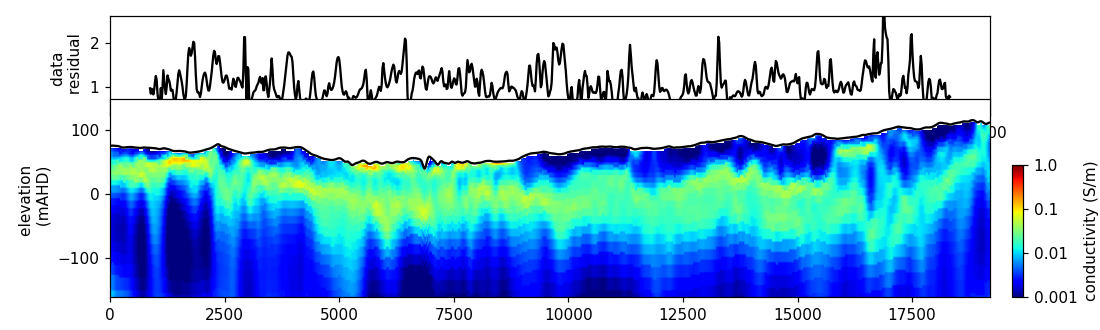

In [55]:
# Create a figures

fig = plt.figure(figsize = (10,3))

# Add two axes for the data misfit and the conductivity
# 
ax1 = fig.add_axes([0.1, 0.65, 0.8, 0.3])
ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.60])

# Add a color
cbar_ax = fig.add_axes([0.92, 0.1, 0.01, 0.4])

panel_kwargs = [{'title': '',
                      'color': 'black',
                      'ylabel': 'data \n residual',
                      'legend': False},
                     {'max_depth': 200.,
                      'shade_doi': False,
                      'colourbar': True,
                      'colourbar_label': 'Conductivity (S/m)',
                      'log_plot': True,
                      'vmin': 0.001,
                      'vmax': 1.,
                      'cmap': 'jet',
                      'ylabel': 'elevation \n (mAHD)'}]

# define your line
line = 105701

res = plots.plot_single_line(ax1, lci.section_data[line],
                                   'data_residual', panel_kwargs[0])

im = plots.plot_grid(ax2, lci.section_data[line], 'conductivity',
                           panel_kwargs[1])

cb = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
    
cbar_ax.set_yticklabels([round(10 ** x, 4) for x in cb.get_ticks()])

cb.set_label('conductivity (S/m)', fontsize=10)

plt.show()

# 3 Setup your model

Now we want to create a model boundary object for our interpreted surface. As with AEM inversions our interpreted surface will be an instance of a python class. However, this class is called modelled boundary and has different data and funcionality.

In [25]:
import importlib
importlib.reload(modelling_utils)

<module 'modelling_utils' from '../scripts/modelling_utils.py'>

In [35]:
# Create an modelled boundary instance

surface = modelling_utils.modelled_boundary(name = 'Oolloo-Jinduckin interface - elevation')

# If we have an extent we can load that as an attribute
infile = "../../workshop_data/interpretation/Oolloo_extent.shp"

surface.load_extent_from_file(infile)


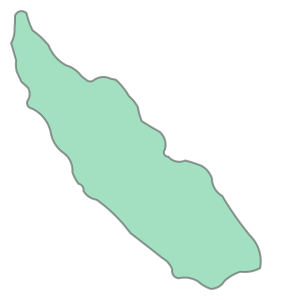

In [45]:
surface.extent

Often there wil be some point saved to disk. These may have been interpretation points
from another session or from another source. These can be loaded with the load_interpretation_points_from_file()
function. It is important that the schema of this file is correct

In [36]:
# path to csv file
infile = "../../workshop_data/interpretation/rj_interp.csv"

# now lets examine the file using a package called pandas. This
# package excels at processing tabular data such like our point data

# load the data into "dataframe", which is a p
# pandas object
df_pts = pd.read_csv(infile)

# print the dataframe summary statistics and top three rows
print(df_pts.describe())
print(df_pts.head(3))


           fiducial        easting      northing  layer_depth  \
count  4.300000e+01      43.000000  4.300000e+01    43.000000   
mean   1.196524e+06  752396.918140  8.443572e+06   247.302326   
std    8.472656e+04    6975.225078  9.639995e+03    65.318099   
min    1.124803e+06  741491.690000  8.423438e+06    54.000000   
25%    1.130658e+06  747193.280000  8.436798e+06   214.000000   
50%    1.141026e+06  750962.750000  8.445592e+06   246.000000   
75%    1.301906e+06  756673.470000  8.450296e+06   290.000000   
max    1.389236e+06  772582.120000  8.458588e+06   366.000000   

       layer_elevation  standard_deviation  
count        43.000000           43.000000  
mean       -173.448605           19.639491  
std          69.882998           12.732547  
min        -312.660000            3.397287  
25%        -228.215000            8.493218  
50%        -161.820000           15.287792  
75%        -128.465000           29.787792  
max           5.010000           50.000000  
    fiduc

In [37]:
# If we are satisfied we can load the points

surface.load_interpretation_points_from_file(infile)


# 3.2 Create a modelling grid

Here we define our grid. While we are actually interpreting at points, this notebook allows on the fly interpolation to help the interpreter. This is not meant to replace gridding the final product, but rather to reduce the need to constantly jump between software packages. In this case we are using a gaussian process with a Matern kerenl.

In [38]:
# Our surface will be modelled onto a grid which we will define
# based on our own project objectives

# Define the grid bounds
ymin, ymax, = 8400000, 8480000
xmin, xmax = 725000, 800000
cell_size = 500.

# If the surface is not converging it is definitely worth playing with
# length_scale_bounds to achieve the grid you want

kernels = [Matern(nu = 1.5, length_scale_bounds = [1000,10000]),
           Matern(nu = 1.5, length_scale_bounds = [2000,10000])]

inteporlation_variables = ['layer_elevation', 'standard_deviation']

# Create our regular grid
surface.create_grid(xmin, xmax, ymin, ymax, cell_size = cell_size, convex_hull = False)


# No lets interpolate both variables in inteporlation_variables

# Loop through them

for i, var in enumerate(inteporlation_variables):
    
    # Create an interpolator for gridding point data. Thus far I have only implemented a Gaussian Process
    interpolator_name = var + "_gp"
    
    grid_name = var + '_grid'
    
    print(var)
    
    surface.create_interpolator(kernel = kernels[i],
                                name = interpolator_name)

    # If we have points we can fit our interpolation

    surface.fit_interpolator(variable = var,
                             interpolator_name = interpolator_name)

    surface.predict_on_grid(interpolator_name = interpolator_name, 
                            grid_name = grid_name)


layer_elevation
standard_deviation


We can plot these grids as we update the points. To make this easier the interpreted_surface_dual_plot() updates the interpolation and plots the results for two variables. Below we demonstrate on layer_elevation and standard_deviation variables. 

<IPython.core.display.Javascript object>


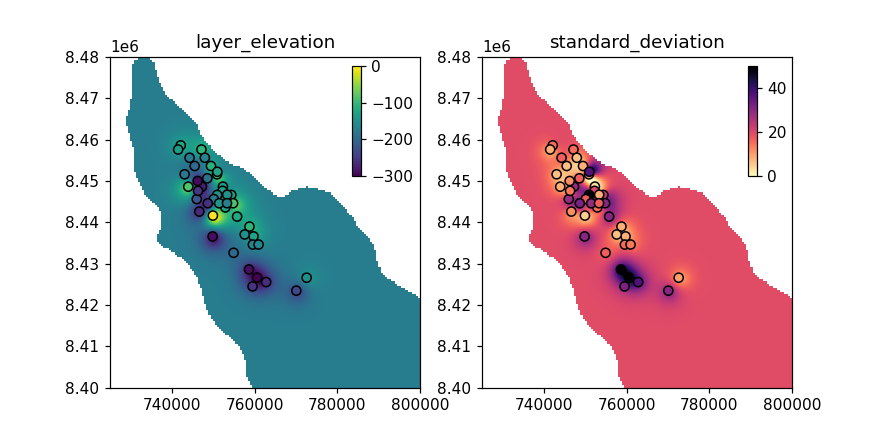

In [39]:
# Once again the plot arguments are given as a dictionary.
# here we define one for each panel. We incl
plot_args = {'Panel_1': {'variable': 'layer_elevation',
                         'grid': 'layer_elevation_grid',
                         'interpolator': 'layer_elevation_gp',
                          "vmin": -300., "vmax": 0.,
                         'colour_stretch': 'viridis'},
             
            'Panel_2': {'variable': 'standard_deviation',
                         'grid': 'standard_deviation_grid',
                         'interpolator': 'standard_deviation_gp',
                         "vmin": 0., "vmax": 50.,
                         'colour_stretch': 'magma_r'},
            'fig_args': {'figsize': (8,4)}}

plt.close('all')

fig, ax_array, cax_array = plots.interpreted_surface_dual_plot(surface, plot_args = plot_args,
                                                               update_grid = True)

plt.show()

In [40]:
# This function stores the top of the conductor in the dataframe on a click
outfile = "../../workshop_data/interpretation/rj_interp.csv"

interpretations = []

def pmap_click(event):
    if event.xdata != None and event.ydata != None:
        #We will use fiducial as a key

        depth, stdev = modelling_utils.click2estimate(D, event.ydata,
                                                       snap_window = 16,
                                                       stdev_ceiling = 50.)
        # append to the surface object interpreted points
        interp = {'fiducial': D['fiducial'],
                  'easting': D['easting'],
                  'northing': D['northing'],
                  'layer_depth': np.round(depth,0),
                  'layer_elevation': np.round(D['elevation'] - event.ydata,2),
                  'standard_deviation': np.round(stdev,0)}
        
        #interpretations.append(interp)                        
        df = pd.DataFrame(interp, index = [0]).set_index('fiducial')
        # Add to surface
        try:
            surface.interpreted_points = surface.interpreted_points.append(df,
                                                                           verify_integrity = True)
        except ValueError:
            print('Replacing existing interpretations')
            surface.interpreted_points.loc[df.index, df.columns] = df.values[0]

        # Save the interpretation
        surface.interpreted_points.to_csv(outfile)
        

# 4 Start interpreting

We are now ready to start interpreting within the notebook.



In [41]:
## 
def pmap_plot(D, figsize = (8,8), outfile = None):
    
    fig = plt.figure(figsize = figsize)

    ax1 = fig.add_axes([0.05, 0.35, 0.35, 0.62])
    ax2 = fig.add_axes([0.45, 0.35, 0.2, 0.62])
    ax3 = fig.add_axes([0.70, 0.52, 0.2, 0.2])
    ax4 = fig.add_axes([0.72, 0.32, 0.16, 0.16])
    ax5 = fig.add_axes([0.1, 0.18, 0.76, 0.05])
    ax6 = fig.add_axes([0.1, 0.05, 0.76, 0.13])
    ax7 = fig.add_axes([0.70, 0.78, 0.2, 0.2])
    cbar_ax1 = fig.add_axes([0.05, 0.29, 0.35, 0.01])
    cbar_ax2 = fig.add_axes([0.88, 0.05, 0.01, 0.2])
    cbar_ax3 = fig.add_axes([0.9, 0.52, 0.01, 0.2])
    
    panel_kwargs = [{'title': '',
                      'color': 'black',
                      'ylabel': 'data \n residual',
                      'legend': False},
                     {'title': 'LCI conductivity',
                      'max_depth': 500.,
                      'shade_doi': False,
                      'colourbar': True,
                      'colourbar_label': 'Conductivity (S/m)',
                      'log_plot': True,
                      'vmin': 0.001,
                      'vmax': 2.,
                      'cmap': 'jet',
                      'ylabel': 'elevation \n (mAHD)',
                      'vertical_exaggeration': 1.0}]


    # Plot probability map
    
    # ax1
    im = ax1.imshow(D['conductivity_pdf'], extent = D['conductivity_extent'],
                    aspect = 'auto', cmap = 'rainbow')
    
    #  PLot the median, and percentile plots
    ax1.plot(np.log10(D['cond_p10']), D['depth_cells'], c = 'k',linestyle='dashed', label = 'p10')
    ax1.plot(np.log10(D['cond_p90']), D['depth_cells'], c = 'k',linestyle='dashed', label = 'p90')
    ax1.plot(np.log10(D['cond_p50']), D['depth_cells'], c = 'k',label = 'p50')
    ax1.plot(np.log10(D['cond_mean']), D['depth_cells'], c = 'grey',label = 'mean')
    
    ax1.set_xticklabels([round(10 ** float(x), 4) for x in ax1.get_xticks()])

    # for lci layered model we do some processing
    lci_expanded = np.zeros(shape=2 * len(D['lci_cond']) + 1,
                                 dtype=np.float)

    lci_expanded[1:] = np.repeat(D['lci_cond'], 2)

    depth_expanded = (np.max(D['lci_depth_top']) + 10) * np.ones(shape=len(lci_expanded),
                                                            dtype=np.float)

    depth_expanded[:-1] = np.repeat(D['lci_depth_top'], 2)

    ax1.plot(np.log10(lci_expanded), depth_expanded, c = 'pink',
             linestyle = 'dashed', label = 'lci')
    ax1.plot(ax1.get_xlim(), [D['lci_doi'], D['lci_doi']], c = 'yellow',
             label = 'LCI doi')
    ax1.set_title('rj-MCMC probability map')
    ax1.set_ylabel('depth (mBGL)')
    ax1.set_xlabel('Conductivity (S/m)')
    ax1.grid(which = 'both')
    ax1.set_xlim(D['conductivity_extent'][0], D['conductivity_extent'][1] )
    
    ax1.set_ylim(D['conductivity_extent'][2], D['conductivity_extent'][3])

    ax1.legend(loc = 3)
    
    # Ax 2
    ax2.plot(D['change_point_pdf'], D['depth_cells'], label = 'P(change point)')
    ax2.set_ylim(ax2.get_ylim()[::-1])
    ax2.set_yticks(np.arange(0, 500, 20.))
    ax2.set_title('change point probability')
    ax2.set_ylim(D['conductivity_extent'][2], D['conductivity_extent'][3])#(100.,0)

    ax2.legend()
    ax2.grid(which = 'both')
    
    elevation_grid = surface.layer_elevation_grid
    extent = surface.bounds
    
    im3 = ax3.imshow(elevation_grid,extent = extent, vmin = -300, vmax = 0)
    
    ax3.scatter(surface.interpreted_points['easting'],
                surface.interpreted_points['northing'], c='k',
                marker = '+')

    ax3.plot(D['easting'],D['northing'],  'x', c = 'red')
        
    # Ax 4
    sample = D['sample_no'][:]
    
    # Add the misfit
    for i in range(D['misfit'].shape[0]):
       
        misfits = D['misfit'][i]
        ax4.plot(sample, misfits/D['ndata'])

    ax4.plot([1, D['nsamples']], [1,1], 'k')
    ax4.plot([D['burnin'], D['burnin']],[0.1,1e4], 'k')
    ax4.set_xlim([1, D['nsamples']])
    ax4.set_ylim(0.1, 1e4)

    ax4.set_xscale('log')
    ax4.set_yscale('log')

    ax4.set_xlabel("sample #")
    ax4.set_ylabel("Normalised misfit")
    
    # Ax 5
    

    res1 = plots.plot_single_line(ax5, lci.section_data[line],
                                   'data_residual', panel_kwargs[0])

    ax5.set_title('LCI conductivity section - ' + str(line))
    
    # Ax 6

    im2 = plots.plot_grid(ax6, lci.section_data[line], 'conductivity',
                               panel_kwargs[1])

    ax6.plot([dist, dist], [-500, 500], 'pink')
    ax6.set_xlabel("Distance along line (m)")
    
    

    # Ax7
    cond_grid = np.log10(lci.layer_grids['Layer_9']['conductivity'])

    im = ax7.imshow(cond_grid, extent = lci.layer_grids['bounds'],
                     cmap = panel_kwargs[1]['cmap'],
                     vmin = np.log10(panel_kwargs[1]['vmin']),
                     vmax =np.log10(panel_kwargs[1]['vmax']))
    
    ax7.set_xlim(D['easting'] - 10000., D['easting'] + 10000.)
    ax7.set_ylim(D['northing'] - 10000., D['northing'] + 10000.)
    ax7.plot(D['easting'],D['northing'],  'x', c = 'k')
    
    p1 = [lci.section_data[line]['easting'][0], lci.section_data[line]['easting'][-1]]
    p2 = [lci.section_data[line]['northing'][0], lci.section_data[line]['northing'][-1]]
    ax7.plot(p1, p2, 'k', linewidth = 0.5)
    ax7.set_title('LCI depth slice 9', fontsize=10)
    ax7.tick_params(axis='both', which='major', labelsize=8)
    ax7.tick_params(axis='both', which='minor', labelsize=8)
    
    # cbar axes
    cb1 = fig.colorbar(im, cax=cbar_ax1, orientation='horizontal')
    cb1.set_label('probabilitiy', fontsize=10)
    
        
    cb2 = fig.colorbar(im2, cax=cbar_ax2, orientation='vertical')
    
    cb2.ax.set_yticklabels([round(10 ** x, 4) for x in cb2.get_ticks()])
    cb2.set_label('conductivity (S/m)', fontsize=10)
    
    cb3 =  fig.colorbar(im3, cax=cbar_ax3, orientation='vertical')
    cb3.set_label('surface elevation mAHD')
    
    ax5.set_xlim(dist - 5000.,
                 dist + 5000.)
    ax6.set_xlim(dist - 5000., 
                 dist + 5000.)

    ax_array = np.array([ax1, ax2, ax3, ax4, ax5, ax6, ax7])
    
    return fig, ax_array   

In [44]:
point_index = points[0]

In [65]:
mask = np.where([Point(rj.coords[id]).within(surface.extent) for id in points])[0]
points = points[mask]

TypeError: only integer scalar arrays can be converted to a scalar index

In [67]:
points

[98,
 28,
 228,
 169,
 170,
 242,
 245,
 257,
 268,
 281,
 288,
 287,
 287,
 296,
 294,
 294,
 298,
 308,
 311,
 311,
 300,
 291,
 277,
 277,
 234]

1142003.0


<IPython.core.display.Javascript object>


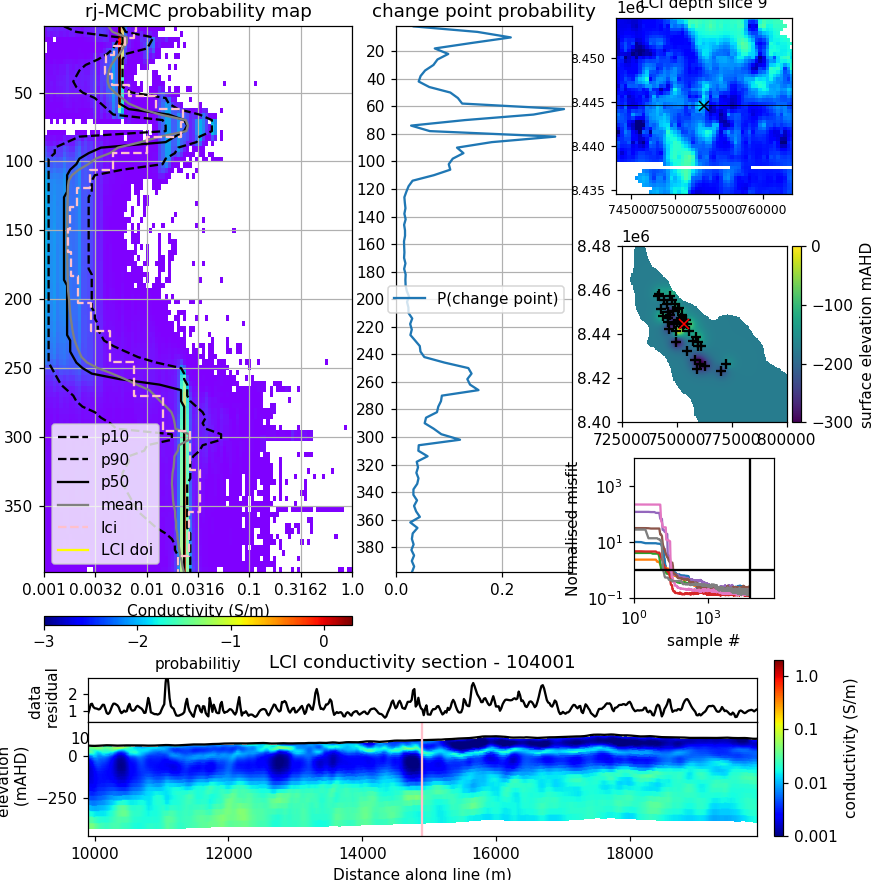

In [43]:
plt.close('all')

D = netcdf_utils.extract_rj_sounding(rj, lci, point_index)

print(D['fiducial'])

line = np.int(rj.data['line'][point_index].data)

# Find distance along the lci section
dist = spatial_functions.xy_2_var(lci.section_data[line],
                 np.array([[D['easting'], D['northing']]]),
                 'grid_distances')

point_ind_lci = dist

fig, ax_array = pmap_plot(D)


plt.show()

cid=  fig.canvas.mpl_connect('button_press_event', pmap_click)